In [1]:
import pandas as pd
import numpy as np
import scipy as sc


import warnings 
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
%pylab inline

import datetime
import dateutil.relativedelta

import urllib

Populating the interactive namespace from numpy and matplotlib


In [2]:
Liabilities = ['DataDate', 'company','Sector',
                  'STD', 'LTD', 'other_liabilities',
                  'acc_payable','int_exp', 'liabilities_total']

Equity = ['DataDate', 'GVKey','Iid','Sector',
             'equity', 'Retained Earnings', 'stockholders_equity',
             'tangible_equity','book_value_per_share', 
             'Invested_capital', 'preference_stock' ]

Assets = ['DataDate', 'GVKey','Iid','Sector',
             'cur_assets', 'total_assets','cash', 
             'intangible_assets', 'inventories', 'acc_receivables']

PL = ['DataDate', 'GVKey','Iid','Sector',
         'sales', 'COGS', 'amort','Other_exp', 'ebit', 
         'interests_paid_net','tax', 'deferred_taxes', 
         'deferred_taxes_fed','deferred_taxes_foreign', 'income_taxes' ]

CF = ['DataDate', 'GVKey','Iid','Sector',
         'capex', 'dividends', 'op_act_net_CF', 
         'op_inc_after_dep', 'op_in_before_dep']

other = ['DataDate', 'GVKey','Iid','Sector',
            'employees', 'minority_interests', 
            'noncontrolling_interests', 'marketable_sec', 
            'working_cap', 'mii', 'Implied Option Expense']

Coef_tab = ['DataDate', 'GVKey','Iid','Sector',
               'EarningsYld', 'EpsGrowth1Yr', 'GrossMargin', 
               'OperatingMargin','PriceBook', 'ROA', 'ROE', 
               'SalesGrowth1Yr', 'SalesGrowth5Yr', 'SalesYld' ]

In [3]:
dd = pd.read_excel('New_Market_Data.xlsx')
dd.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
df = pd.read_excel('New_Fundamental_Data.xlsx')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.drop_duplicates(inplace=True)

In [5]:
l = df[['company', 'Sector', 'DataDate']]
index = l[l.duplicated(keep = False)].index
df.drop(index, inplace = True)

In [13]:
df = df.iloc[:-7,:]

In [6]:
wacc = pd.read_excel('wacc.xlsx')

# Считаем Доли долга и Доли собственного капитала
DE = pd.read_excel('DE.xlsx')
D = DE[['Date_1', 'gvkey', 'D']]
D = D.rename(columns = {'Date_1': 'Date'})
E = DE[['Date_2', 'gvkey.1', 'MkVal']]
E = E.rename(columns = {'Date_2': 'Date', 'gvkey.1': 'gvkey'})
DE = D.merge(E)
DE['dD'] = DE['D']/ (DE['MkVal'] + DE['D'])
DE['dE'] = DE['MkVal']/ (DE['MkVal'] + DE['D'])
DE = DE.rename(columns = {'Date': 'Year', 'gvkey': 'FIRM'})
DE = DE.assign(Year=DE.Year.dt.year)
DE.drop_duplicates(inplace=True)
DE.dropna(inplace=True)

naming = pd.read_excel('my_excel_file.xlsx')

list = []
for element in DE['FIRM']:
    if element in np.array(naming['GVKey']):
        list.append(1)
    else:
        list.append(0)

DE['indexing'] = list
DE = DE[DE.indexing == 1]

DE['company'] = 'new_name'
DE['label'] = 'new_label'
for element in np.array(naming['GVKey']):
    DE['company'][DE['FIRM'] == element] = np.array(naming['Company'][naming['GVKey'] == element])[0]
    DE['label'][DE['FIRM'] == element] = np.array(naming['Label'][naming['GVKey'] == element])[0]

wacc = pd.merge(wacc, DE, how = 'left')
wacc.drop_duplicates(inplace = True)
wacc['dD'] = wacc.groupby('company')['dD'].fillna(method='ffill')
wacc['dE'] = wacc.groupby('company')['dE'].fillna(method='ffill')

wacc['dD'] = wacc.groupby('company')['dD'].fillna(method='bfill')
wacc['dE'] = wacc.groupby('company')['dE'].fillna(method='bfill')

tax = df[['DataDate', 'label','income_taxes', 'ebit']]
tax.dropna(inplace = True)
tax['dtax'] = tax['income_taxes']/ tax['ebit']
tax = tax.rename(columns = {'DataDate' : 'Year'})
tax = tax.assign(Year=tax.Year.dt.year)
wacc = pd.merge(wacc, tax, how = 'left')
wacc['income_taxes'] = wacc.groupby('company')['income_taxes'].fillna(method='ffill')
wacc['income_taxes'] = wacc.groupby('company')['income_taxes'].fillna(method='bfill')

wacc = wacc[['Year', 'company', 'label','Re', 'dE', 'Rd', 'dD','dtax', 'beta', 'ERP', 'Rf', 'spread',   'D', 'MkVal' ]]

wacc['wacc'] = wacc['dD'] * wacc['Rd'] * (1-wacc['dtax'])  + wacc['dE'] * wacc['Re']

In [14]:
div = df[['DataDate', 'company', 'dividends', 'total_assets']]

div['DataDate+1m'] = [element + dateutil.relativedelta.relativedelta(months=1) for element in div['DataDate']]
div['DataDate+1m+1d'] = [element + dateutil.relativedelta.relativedelta(day=31) for element in div['DataDate+1m']]

div['DataDate-1y'] = [element - dateutil.relativedelta.relativedelta(months=12) for element in div['DataDate']]
div['DataDate-1ym'] = [element - dateutil.relativedelta.relativedelta(months=11) for element in div['DataDate']]
div['DataDate-1ym+1d'] = [element + dateutil.relativedelta.relativedelta(day=31) for element in div['DataDate-1ym']]
div.dropna(inplace = True)

MK = dd[['DataDate', 'company', 'MK']]
MK['DataDate+1m'] = MK['DataDate']
MK['DataDate+1m+1d'] = MK['DataDate']
MK['DataDate-1y'] = MK['DataDate']
MK['DataDate-1ym'] = MK['DataDate']
MK['DataDate-1ym+1d'] = MK['DataDate']

tsr = pd.merge(div, MK[['DataDate', 'company', 'MK']], how = 'left', on = ['DataDate', 'company'])
tsr = pd.merge(tsr, MK[['DataDate+1m', 'company', 'MK']], how = 'left', on = ['DataDate+1m', 'company'])
tsr = pd.merge(tsr, MK[['DataDate+1m+1d', 'company', 'MK']], how = 'left', on = ['DataDate+1m+1d', 'company'])
tsr = pd.merge(tsr, MK[['DataDate-1y', 'company', 'MK']], how = 'left', on = ['DataDate-1y', 'company'])
tsr = pd.merge(tsr, MK[['DataDate-1ym', 'company', 'MK']], how = 'left', on = ['DataDate-1ym', 'company'])
tsr = pd.merge(tsr, MK[['DataDate-1ym+1d', 'company', 'MK']], how = 'left', on = ['DataDate-1ym+1d', 'company'])

tsr.columns = ['DataDate', 'company', 'dividends', 'total_assets', 'DataDate+1m',
       'DataDate+1m+1d', 'DataDate-1y', 'DataDate-1ym', 'DataDate-1ym+1d',
       'MK_now', 'MK_now+1m', 'MK_now+1m+1d','MK_-1y', 'MK_-1ym', 'MK_-1ym+1d' ]

tsr.MK_now = tsr.MK_now.fillna('abu')
tsr.MK_now = tsr.MK_now.where(tsr.MK_now != 'abu', tsr['MK_now+1m'])
tsr.MK_now = tsr.MK_now.fillna('abu')
tsr.MK_now = tsr.MK_now.where(tsr.MK_now != 'abu', tsr['MK_now+1m+1d'])

tsr['MK_-1y'] = tsr['MK_-1y'].fillna('abu')
tsr['MK_-1y'] = tsr['MK_-1y'].where(tsr['MK_-1y'] != 'abu', tsr['MK_-1ym'])
tsr['MK_-1y'] = tsr['MK_-1y'].fillna('abu')
tsr['MK_-1y'] = tsr['MK_-1y'].where(tsr['MK_-1y']!= 'abu', tsr['MK_-1ym+1d'])


tsr.MK_now = tsr.MK_now.astype('float64')
tsr['MK_-1y'] = tsr['MK_-1y'].astype('float64')

tsr.rename(columns= {'MK_now':'MK', 'MK_-1y':'MK_y'}, inplace = True)

tsr['tsr'] = (tsr['dividends'] / tsr['MK_y']) + ((tsr['MK'] - tsr['MK_y'])/ tsr['MK_y'])

In [15]:
features_list = ['DataDate', 'company', 'label', 'Sector', 'current_ratio', 'icr', 'std_coef', 'ebit/sales', 
                 'ROCE', 'eva', 'sales_growth', 'cvadrant', 'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA', 
                 'Div/MV', 'Div Payout Ratio', 'TSR']
#'K_n', 'SGI',

features = df[['DataDate', 'label', 'company', 'Sector', 'cur_assets', 'STD', 'LTD', 'int_exp',
               'acc_payable', 'ebit', 'amort', 'total_assets', 'SalesGrowth1Yr', 'SalesYld', 
              'sales', 'GrossMargin', 'income_taxes', 'Invested_capital', 'dividends', 'ROE', 'net_income' ]]

features = pd.merge(features, tsr[['DataDate', 'company','MK', 'MK_y']], how = 'left', on = ['DataDate', 'company'])
features['Year'] = pd.DatetimeIndex(features['DataDate']).year

features = pd.merge(features, wacc[['Year', 'company', 'wacc']], how = 'left', on = ['Year', 'company'])
features = features.drop_duplicates()

features['EV'] =  features['MK'] + features['LTD'] + features['STD']
features['ebitda'] = features['ebit'] + features['amort']

In [16]:
#
features['current_ratio'] = features['cur_assets']/(features['STD']+ features['int_exp'] + features['acc_payable'] )
features['current_ratio'] = features['current_ratio'].where(features['current_ratio'] < 150, 150)
#

#
features['icr'] = features['ebit']/features['int_exp']
features['icr'] = features['icr'].where(features['icr'] != inf, 100)
features['icr'] = features['icr'].where(features['icr'] != -inf, 0)
features['icr'] = features['icr'].where(features['icr'] < 1500, 1500)
#

#
features['std_coef'] = features['STD']/ (features['LTD'] + features['STD'])
#

#
features['ebit/sales'] = features['ebit'] / features['sales']
#

#
features['ROCE'] = features['ebit'] / (features['total_assets'] - (features['STD'] + features['int_exp'] + features['acc_payable']))
#

# EVA = (ROIC - WACC) X Invested Capital
features['eva'] =  (((features['ebit'] - features['income_taxes']) / 
                     features['Invested_capital']) - features['wacc']) * features['Invested_capital']
#

#!!!!!!!!!!!!
# features['K_n'] = 0 
#!!!!!!!!!!!!

#
features['sales_growth'] = features['SalesGrowth1Yr']
#

# !!!!!!!!!!!
# features['SGI'] = 0 
# !!!!!!!!!!

# 
features['SGR'] =  features['ROE'] * (1 - features['dividends'] / features['net_income'])
features['spread_m'] = features['ROCE'] - features['wacc']
features['av_SGR'] = features.groupby(['Year', 'Sector'])["SGR"].transform("median")
features['av_spread_m'] = features.groupby(['Year', 'Sector'])["spread_m"].transform("median")
conditions = [
    (features['SGR'] >= features['av_SGR']) & (features['spread_m'] >= features['av_spread_m']),
    (features['SGR'] >= features['av_SGR']) & (features['spread_m'] <= features['av_spread_m']),
    (features['SGR'] <= features['av_SGR']) & (features['spread_m'] >= features['av_spread_m']),
    (features['SGR'] <= features['av_SGR']) & (features['spread_m'] <= features['av_spread_m'])]
choices = [1, 3, 2, 4]
features['cvadrant'] = np.select(conditions, choices, default=0)
#

# 
features['NA'] = features['total_assets'] - (features['LTD'] + features['STD'])
#

# 
features['BV/MV'] = features['total_assets'] / features['MK']
#

# !!!!!!!!!!
features['EBITDA/EV'] = features['ebitda'] / features['EV']
# !!!!!!!!!!

# !!!!!!!!!!
features['Debt/EBITDA'] = (features['LTD'] + features['STD']) / features['ebitda']
# !!!!!!!!!!

# !!!!!!!!!!
features['Div/MV'] = features['dividends'] / features['MK']
# !!!!!!!!!!

# !!!!!!!!!!
features['Div Payout Ratio'] = features['dividends'] / features['net_income']
features['Div Payout Ratio'] = features['Div Payout Ratio'].where(features['Div Payout Ratio'] != inf, 100)
features['Div Payout Ratio'] = features['Div Payout Ratio'].where(features['Div Payout Ratio'] != -inf, 0)
features['Div Payout Ratio'] = features['Div Payout Ratio'].where(features['Div Payout Ratio'] < 1500, 1500)
# !!!!!!!!!!

features['TSR'] = (features['dividends'] / features['MK_y']) + ((features['MK'] - features['MK_y'])/ features['MK_y'])

features = features[features_list]

In [17]:
features['BV/MV'] = features['BV/MV'].astype('float64')
features['TSR'] = features['TSR'].astype('float64')

In [18]:
ind = np.array([])
for element in features.columns[4:]:
    outliers = np.array(features[features.groupby('company')[element].apply(lambda x: np.abs(x - x.median()) > \
                                                             (3 * 1.4826 * x.mad()))].any(axis=1).index)
    outliers = [index for index in outliers if index not in ind]
    ind =  np.concatenate((outliers, ind), axis=None)

features.drop(ind, inplace = True)

In [22]:
features.reset_index(drop = True, inplace = True)

In [23]:
features.columns

Index(['DataDate', 'company', 'label', 'Sector', 'current_ratio', 'icr',
       'std_coef', 'ebit/sales', 'ROCE', 'eva', 'sales_growth', 'cvadrant',
       'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA', 'Div/MV', 'Div Payout Ratio',
       'TSR'],
      dtype='object')

In [29]:
features[['current_ratio', 'icr','std_coef', 'ebit/sales', 'ROCE', 'eva', 'sales_growth', 'cvadrant',
       'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA', 'Div/MV', 'Div Payout Ratio']].describe().T.to_excel('describe_table_init.xlsx')

In [39]:
features['Year'] = features['DataDate'].dt.year
sec_features = pd.DataFrame(features.groupby(['Year','Sector'])['current_ratio'].mean()).reset_index()
sec_features = sec_features.rename(columns = {'current_ratio':'current_ratio_sec'})
for ind in features.columns[5:-1]:
    sec_features[ind + '_sec'] = pd.DataFrame(features.groupby(['Year','Sector'])[ind].median()).reset_index().iloc[:, 2]

In [40]:
features = pd.merge(features, sec_features, how = 'left', on = ['Year', 'Sector'])
features = features.iloc[:-1, :]

In [41]:
features_col = ['current_ratio', 'icr', 'std_coef', 'ebit/sales', 'ROCE', 'eva', 
                'sales_growth', 'cvadrant', 'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA', 
                'Div/MV', 'Div Payout Ratio', 'TSR']
for feature in features_col:
    features[feature + '_sec_rel'] = np.log(features[feature]/features[feature + '_sec'])
    features.drop(columns = feature + '_sec', inplace = True)


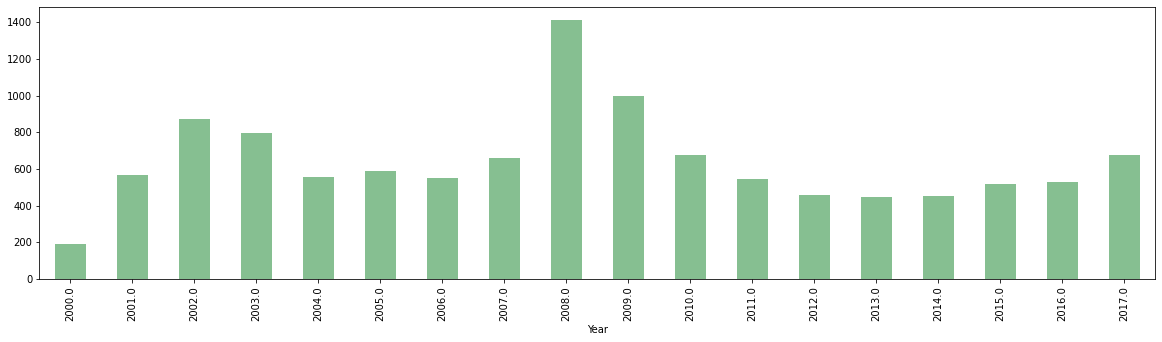

In [46]:
features_nan = features
features_nan['NAN'] = features_nan.isnull().sum(axis = 1)

ax = features_nan.groupby('Year')['NAN'].sum().plot(kind='bar', color='#86bf91', 
                            zorder=2, figsize = (20,5)) 
plt.xticks(np.arange(len(features_nan.Year.drop_duplicates())), 
           features_nan.Year.drop_duplicates(), rotation=90)
plt.show()

In [43]:
features = features[features.Year < 2018]

In [47]:
for feature in features.columns:
    features[feature] = features[feature].where(features[feature] != -inf, 0)
    features[feature] = features[feature].where(features[feature] != inf, 0)

In [45]:
features.drop(columns = ['TSR_sec_rel'], inplace = True)

In [147]:
features_stat = features.describe().T[['count', '50%','mean', 'std']].round(2)
features_stat
features_stat.to_excel('in_features_stat.xlsx')

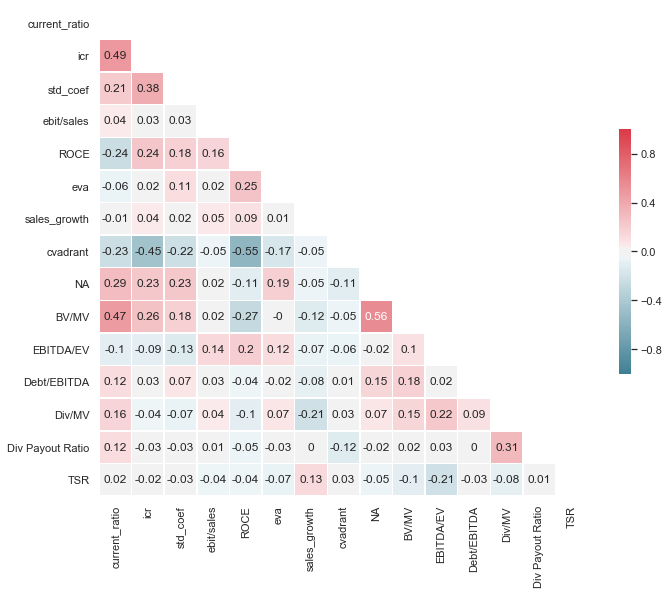

In [139]:
%config InlineBackend.figure_format = 'png' 
sns.set(style="white", palette = 'coolwarm')

# Compute the correlation matrix
corr = features.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center = 0, vmin= -1, vmax = +1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

In [49]:
features_zero = features.fillna(0)
features_zero.reset_index(inplace = True)
features_zero.drop(columns = ['index'], inplace = True)
l = features_zero[['company', 'Sector', 'DataDate']]
index = l[l.duplicated(keep = False)].index
features_zero.reset_index(drop = True, inplace = True)
features_zero.drop(index, inplace = True)
features.drop(columns = ['Year','cvadrant_sec_rel',  'NAN'] , inplace = True)
features_zero.to_excel('features_zero.xlsx')

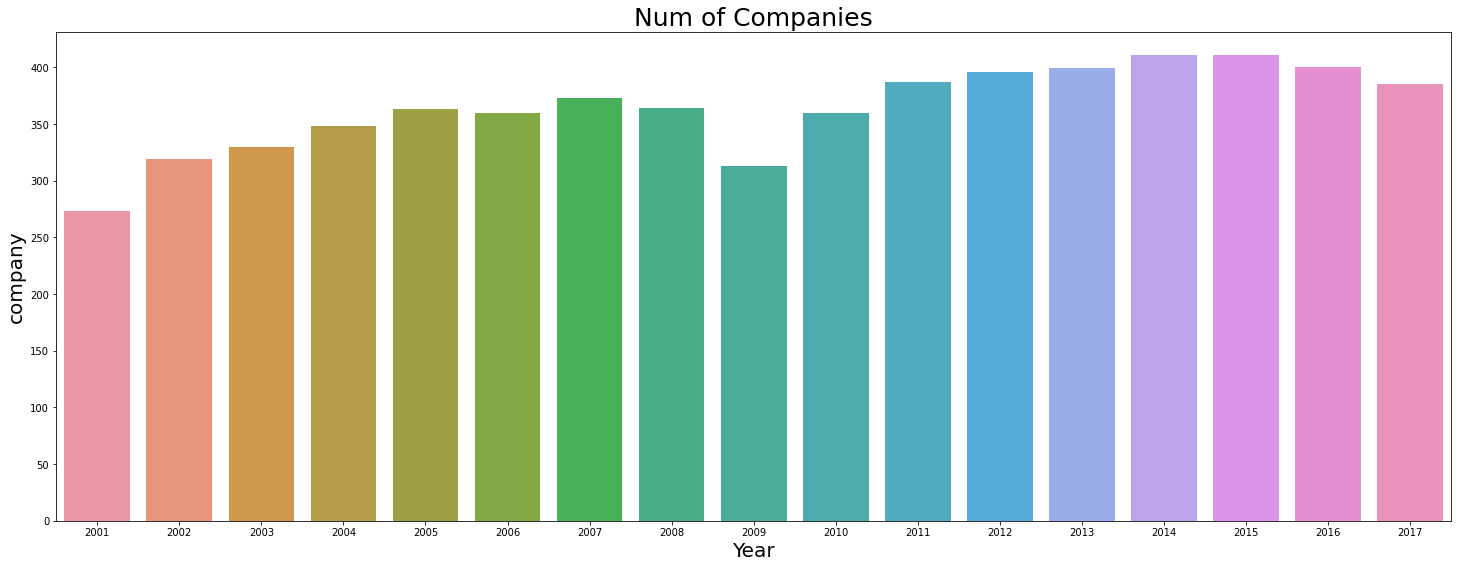

In [48]:
features['Year'] = pd.DatetimeIndex(features['DataDate']).year
Z = pd.DataFrame(features.groupby('Year')['company'].count())
Z.reset_index(inplace = True)
Z = Z[Z.Year > 2000]
Z.Year = Z.Year.astype(int64)
plt.figure( figsize=(25, 9))
plt.title("Num of Companies", fontsize = 25)
plt.xlabel('x', fontsize = 20)
plt.ylabel('y', fontsize = 20)
sns.barplot(x = 'Year', y = 'company', data = Z)